# Data modeling notebook


## Summary
    
   In this notebook I will first preprocess the dataset that was cleaned in data wrangling notebook. For preprocessing I will use sklearn's OneHotEncoder and LabelEncoder. Speciffically, OneHotEncoder for columns that contain nominal values and LabelEncoder for those that contain ordinal values. I made sure that nominal values have small cardinality in the data_wrangling notebook.
    
## Steps
   ### 1. Setting thing up
   * Import libraries
   * Read in cleaned data
   
### 2. Preprocessing 
   * Label encode ordinal values
   * One-hot encode nominal values
   
### 3. Building a model
   * Beayesian hyperparameter optimization
   * Feature importance
   * Recursive feature selection
   * Spearman rank correlation
   
### 4. Model interpretation
   * Partial depandence plots
   * Statistical tests
  
    

### 1. Setting things up

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFE
from eli5.sklearn import PermutationImportance
from eli5 import show_weights
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.cluster import hierarchy as hc
import scipy
import seaborn as sns
from pdpbox import pdp
import xgboost as xgb
from skopt import BayesSearchCV

In [2]:
df = pd.read_csv("./cleaned_loans.csv")
pd.set_option("display.max_rows", 150)
df.head().T

,0,1,2,3,4
loan_amnt,5000,2500,2400,10000,3000
term,36,60,36,36,60
int_rate,10.65,15.27,15.96,13.49,12.69
installment,162.87,59.83,84.33,339.31,67.79
grade,B,C,C,C,B
emp_length,10+ years,< 1 year,10+ years,10+ years,1 year
home_ownership,RENT,RENT,RENT,RENT,RENT
annual_inc,24000,30000,12252,49200,80000
verification_status,Verified,Verified,Not Verified,Verified,Verified
loan_status,1,0,1,1,1


*Let's see how much is the data imbalanced:*

In [3]:
frac_1 = df[df.loan_status == 1].shape[0] / df.shape[0]
frac_0 = df[df.loan_status == 0].shape[0] / df.shape[0]
print(f'fraction of fully paid: {frac_1}\n\nfraction of charged off: {frac_0}')

fraction of fully paid: 0.8577001484911786

fraction of charged off: 0.14229985150882138


## 2. Preprocessing

Lebel enocode "grade" column:

In [4]:
def f(x):
    if x == 'A':
        return 6
    elif x == 'B':
        return 5
    elif x == 'C':
        return 4
    elif x == 'D':
        return 3
    elif x == 'E':
        return 2
    elif x == 'F':
        return 1
    else:
        return 0

In [5]:
df["grade"] = df.grade.apply(f)

Label encode "emp_length" column:

In [6]:
def f(x):
    if x == '10+ years':
        return 10
    elif x == '9 years':
        return 9
    elif x == '8 years':
        return 8
    elif x == '7 years':
        return 7
    elif x == '6 years':
        return 6
    elif x == '5 years':
        return 5
    elif x == '4 years':
        return 4
    elif x == '3 years':
        return 3
    elif x == '2 years':
        return 2
    elif x == '1 year':
        return 1
    else:
        return 0

In [7]:
df["emp_length"] = df.emp_length.apply(f)

Get the feature names for preprocessing:

In [8]:
cat_cols_onehot = ["addr_state",
                   "purpose",
                   "verification_status",
                   "home_ownership"
                  ]
cat_col_label = ["term"]

One-hot encode:

In [9]:
onehot_enc = OneHotEncoder(sparse=False)
onehot_encode_cols = pd.DataFrame(onehot_enc.fit_transform(df[cat_cols_onehot]), 
                                  #PermutationImportance() throws an error if type of a column name is int 
                                  #instead of string so set the column names to categories of onehot encoder
                                  columns=np.concatenate(onehot_enc.categories_, axis=0)
                                 )
onehot_encode_cols.index = df.index

Label incode "term":

In [10]:
label_enc = LabelEncoder()
label_enc_cols = pd.DataFrame()
for col in cat_col_label:
    label_enc_cols[col] = label_enc.fit_transform(df[col])
label_enc_cols.index = df.index

Concatinate all the features back together:

In [11]:
df_preprocessed = pd.concat([onehot_encode_cols, 
                             label_enc_cols,
                             df.drop(cat_col_label + cat_cols_onehot, axis=1)
                            ],
                            axis=1
                           )
df_preprocessed.shape

(39733, 42)

In [12]:
df_preprocessed.describe().T

,count,mean,std,min,25%,50%,75%,max
midwest,39733.0,0.140412,0.347419,0.00,0.00,0.00,0.00,1.00
northeast,39733.0,0.246395,0.430916,0.00,0.00,0.00,0.00,1.00
south,39733.0,0.327587,0.469339,0.00,0.00,0.00,1.00,1.00
west,39733.0,0.285606,0.451708,0.00,0.00,0.00,1.00,1.00
car,39733.0,0.038985,0.193562,0.00,0.00,0.00,0.00,1.00
credit_card,39733.0,0.129238,0.335467,0.00,0.00,0.00,0.00,1.00
debt_consolidation,39733.0,0.469710,0.499088,0.00,0.00,0.00,1.00,1.00
educational,39733.0,0.008104,0.089658,0.00,0.00,0.00,0.00,1.00
home_improvement,39733.0,0.075001,0.263396,0.00,0.00,0.00,0.00,1.00
house,39733.0,0.009614,0.097581,0.00,0.00,0.00,0.00,1.00


In [13]:
df_preprocessed.head().T

,0,1,2,3,4
midwest,0.00,0.00,1.00,0.00,0.00
northeast,0.00,0.00,0.00,0.00,0.00
south,0.00,1.00,0.00,0.00,0.00
west,1.00,0.00,0.00,1.00,1.00
car,0.00,1.00,0.00,0.00,0.00
credit_card,1.00,0.00,0.00,0.00,0.00
debt_consolidation,0.00,0.00,0.00,0.00,0.00
educational,0.00,0.00,0.00,0.00,0.00
home_improvement,0.00,0.00,0.00,0.00,0.00
house,0.00,0.00,0.00,0.00,0.00


Split the data for training and validating:

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(df_preprocessed.drop(["loan_status"], axis=1), 
                                                      df_preprocessed.loan_status,
                                                      test_size=0.1,
                                                      random_state=22
                                                     )

In [15]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]
eval_metric="auc"

### 3. Building a model

Run a Bayes search to tune hyperparameters:

In [16]:
bayes_cv_tuner = BayesSearchCV(
    estimator=xgb.XGBRegressor(
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='approx'
    ),
    search_spaces={
        'learning_rate': (1e-2, 3, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 7),
        'subsample': (0.1, 1.0),
        'colsample_bytree': (0.1, 1.0, 'log-uniform'),
        'gamma': (0.1, 3, 'log-uniform'),
        'n_estimators': (50, 250),
        'scale_pos_weight': (1e-6, 20, 'log-uniform')
    },    
    scoring='roc_auc',
    cv=StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs=2,
    n_iter=10,   
    verbose=0,
    refit=True,
    random_state=42
)

In [17]:
def status_print(optim_result):
    
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)     
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print(f'Model #{len(all_models)}\nBest ROC-AUC: {np.round(bayes_cv_tuner.best_score_, 4)}\nBest params: {bayes_cv_tuner.best_params_}\n')

In [18]:
result = bayes_cv_tuner.fit(X_train.values, y_train.values, callback=status_print)

Model #1
Best ROC-AUC: 0.5
Best params: {'colsample_bytree': 0.25710111426089055, 'gamma': 1.1883357504897696, 'learning_rate': 2.0456302996780806, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 133, 'scale_pos_weight': 0.0003648885221546751, 'subsample': 0.7655538107713785}

Model #2
Best ROC-AUC: 0.5
Best params: {'colsample_bytree': 0.25710111426089055, 'gamma': 1.1883357504897696, 'learning_rate': 2.0456302996780806, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 133, 'scale_pos_weight': 0.0003648885221546751, 'subsample': 0.7655538107713785}

Model #3
Best ROC-AUC: 0.5
Best params: {'colsample_bytree': 0.25710111426089055, 'gamma': 1.1883357504897696, 'learning_rate': 2.0456302996780806, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 133, 'scale_pos_weight': 0.0003648885221546751, 'subsample': 0.7655538107713785}

Model #4
Best ROC-AUC: 0.6783
Best params: {'colsample_bytree': 0.6492261261173567, 'gamma': 0.17942176989034408, 'learning_rate': 0.302994766392

Train an xgboost model:

In [19]:
m = xgb.XGBRegressor(objective="binary:logistic", 
                     learning_rate=0.0775,
                     n_estimators=169,
                     min_child_weight=6,
                     max_depth=6,
                     sub_sample=0.4799,
                     colsample_bytree=0.4141,
                     gamma=1.3974,
                     nthread=-1, 
                     scale_pos_weight=0.0545, 
                     eval_set=eval_set,
                    )
m.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=True)

[0]	validation_0-auc:0.674575	validation_1-auc:0.634915
[1]	validation_0-auc:0.679845	validation_1-auc:0.645727
[2]	validation_0-auc:0.68925	validation_1-auc:0.65503
[3]	validation_0-auc:0.691753	validation_1-auc:0.656902
[4]	validation_0-auc:0.694056	validation_1-auc:0.659051
[5]	validation_0-auc:0.70037	validation_1-auc:0.661207
[6]	validation_0-auc:0.699876	validation_1-auc:0.660405
[7]	validation_0-auc:0.700755	validation_1-auc:0.660702
[8]	validation_0-auc:0.702385	validation_1-auc:0.66262
[9]	validation_0-auc:0.703802	validation_1-auc:0.662911
[10]	validation_0-auc:0.706834	validation_1-auc:0.664479
[11]	validation_0-auc:0.709816	validation_1-auc:0.666537
[12]	validation_0-auc:0.710963	validation_1-auc:0.667003
[13]	validation_0-auc:0.712178	validation_1-auc:0.667005
[14]	validation_0-auc:0.713665	validation_1-auc:0.667291
[15]	validation_0-auc:0.716567	validation_1-auc:0.667032
[16]	validation_0-auc:0.716617	validation_1-auc:0.666109
[17]	validation_0-auc:0.715865	validation_1-a

[144]	validation_0-auc:0.77016	validation_1-auc:0.684192
[145]	validation_0-auc:0.770444	validation_1-auc:0.684115
[146]	validation_0-auc:0.770457	validation_1-auc:0.684106
[147]	validation_0-auc:0.770593	validation_1-auc:0.684146
[148]	validation_0-auc:0.770738	validation_1-auc:0.684253
[149]	validation_0-auc:0.770874	validation_1-auc:0.68428
[150]	validation_0-auc:0.770949	validation_1-auc:0.684417
[151]	validation_0-auc:0.770979	validation_1-auc:0.68438
[152]	validation_0-auc:0.771072	validation_1-auc:0.684372
[153]	validation_0-auc:0.771516	validation_1-auc:0.684751
[154]	validation_0-auc:0.77154	validation_1-auc:0.684819
[155]	validation_0-auc:0.771926	validation_1-auc:0.684993
[156]	validation_0-auc:0.772023	validation_1-auc:0.684932
[157]	validation_0-auc:0.772113	validation_1-auc:0.685004
[158]	validation_0-auc:0.772233	validation_1-auc:0.685074
[159]	validation_0-auc:0.772276	validation_1-auc:0.685041
[160]	validation_0-auc:0.772649	validation_1-auc:0.684954
[161]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4141,
       eval_set=[(       midwest  northeast  south  west  car  credit_card  debt_consolidation  \
2906       0.0        0.0    1.0   0.0  0.0          0.0                 0.0
25978      0.0        1.0    0.0   0.0  0.0          0.0                 0.0
6258       0.0        0.0    0.0   1.0  0.0      ...50     1
7781     1
17861    1
14208    1
39553    1
Name: loan_status, Length: 3974, dtype: int64)],
       gamma=1.3974, importance_type='gain', learning_rate=0.0775,
       max_delta_step=0, max_depth=6, min_child_weight=6, missing=None,
       n_estimators=169, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.0545,
       seed=None, silent=True, sub_sample=0.4799, subsample=1)

Plot the traing and validation scores vs number of trees:

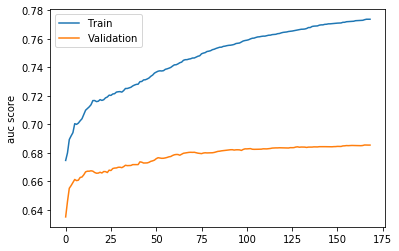

In [20]:
result = m.evals_result()
epochs = len(result['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, result["validation_0"]["auc"], label="Train")
ax.plot(x_axis, result["validation_1"]["auc"], label="Validation")
ax.legend()
plt.ylabel("auc score")
plt.show()

The mode is obviously overfitting. I'm going to use skpot's feature importance to reduce the number of features and combat overfitting.

In [21]:
prm_imp = PermutationImportance(m, random_state=22).fit(X_valid, y_valid)
show_weights(prm_imp, feature_names=X_train.columns.to_list())

Weight,Feature
0.0618 ± 0.0133,annual_inc
0.0508 ± 0.0033,revol_util
0.0439 ± 0.0043,grade
0.0313 ± 0.0107,int_rate
0.0285 ± 0.0035,age_cr_line
0.0211 ± 0.0046,loan_amnt
0.0170 ± 0.0031,revol_bal
0.0164 ± 0.0081,term
0.0162 ± 0.0020,emp_length
0.0159 ± 0.0035,inq_last_6mths


Use sklearn's Recursive Feature Elimination to drop half of the features:

In [22]:
rfe = RFE(m, n_features_to_select=20)
rfe.fit(X_valid, y_valid)
columns = X_valid.columns[rfe.support_].to_list()
X_train_imp = X_train[columns]
X_valid_imp = X_valid[columns]

Train xgboost model on the new dataset:

In [23]:
eval_set = [(X_train_imp, y_train), (X_valid_imp, y_valid)]
eval_metric="auc"

In [24]:
m.fit(X_train_imp, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=True)

[0]	validation_0-auc:0.6823	validation_1-auc:0.647272
[1]	validation_0-auc:0.685864	validation_1-auc:0.6491
[2]	validation_0-auc:0.698289	validation_1-auc:0.659465
[3]	validation_0-auc:0.702695	validation_1-auc:0.66307
[4]	validation_0-auc:0.702519	validation_1-auc:0.663086
[5]	validation_0-auc:0.700976	validation_1-auc:0.661601
[6]	validation_0-auc:0.701442	validation_1-auc:0.659685
[7]	validation_0-auc:0.701282	validation_1-auc:0.661306
[8]	validation_0-auc:0.700312	validation_1-auc:0.661133
[9]	validation_0-auc:0.702406	validation_1-auc:0.662654
[10]	validation_0-auc:0.703679	validation_1-auc:0.664145
[11]	validation_0-auc:0.707052	validation_1-auc:0.665794
[12]	validation_0-auc:0.70763	validation_1-auc:0.66499
[13]	validation_0-auc:0.711004	validation_1-auc:0.666005
[14]	validation_0-auc:0.712977	validation_1-auc:0.667149
[15]	validation_0-auc:0.714316	validation_1-auc:0.667828
[16]	validation_0-auc:0.7153	validation_1-auc:0.669007
[17]	validation_0-auc:0.718149	validation_1-auc:0.

[144]	validation_0-auc:0.762817	validation_1-auc:0.684534
[145]	validation_0-auc:0.762884	validation_1-auc:0.684484
[146]	validation_0-auc:0.763083	validation_1-auc:0.684255
[147]	validation_0-auc:0.763522	validation_1-auc:0.684444
[148]	validation_0-auc:0.763608	validation_1-auc:0.684492
[149]	validation_0-auc:0.764011	validation_1-auc:0.684394
[150]	validation_0-auc:0.764011	validation_1-auc:0.684394
[151]	validation_0-auc:0.764123	validation_1-auc:0.68432
[152]	validation_0-auc:0.764254	validation_1-auc:0.684436
[153]	validation_0-auc:0.764254	validation_1-auc:0.684436
[154]	validation_0-auc:0.76432	validation_1-auc:0.684412
[155]	validation_0-auc:0.764433	validation_1-auc:0.684372
[156]	validation_0-auc:0.764757	validation_1-auc:0.684508
[157]	validation_0-auc:0.764913	validation_1-auc:0.684382
[158]	validation_0-auc:0.765176	validation_1-auc:0.684601
[159]	validation_0-auc:0.765626	validation_1-auc:0.684634
[160]	validation_0-auc:0.765829	validation_1-auc:0.684507
[161]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4141,
       eval_set=[(       midwest  northeast  south  west  car  credit_card  debt_consolidation  \
2906       0.0        0.0    1.0   0.0  0.0          0.0                 0.0
25978      0.0        1.0    0.0   0.0  0.0          0.0                 0.0
6258       0.0        0.0    0.0   1.0  0.0      ...50     1
7781     1
17861    1
14208    1
39553    1
Name: loan_status, Length: 3974, dtype: int64)],
       gamma=1.3974, importance_type='gain', learning_rate=0.0775,
       max_delta_step=0, max_depth=6, min_child_weight=6, missing=None,
       n_estimators=169, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.0545,
       seed=None, silent=True, sub_sample=0.4799, subsample=1)

Check the feature importance again:

In [25]:
prm_imp = PermutationImportance(m, random_state=22).fit(X_valid_imp, y_valid)
show_weights(prm_imp, feature_names=X_train_imp.columns.to_list())

Weight,Feature
0.0609 ± 0.0119,int_rate
0.0567 ± 0.0069,annual_inc
0.0457 ± 0.0063,revol_util
0.0453 ± 0.0080,age_cr_line
0.0370 ± 0.0064,grade
0.0311 ± 0.0060,installment
0.0233 ± 0.0070,emp_length
0.0221 ± 0.0045,loan_amnt
0.0218 ± 0.0042,term
0.0158 ± 0.0041,total_acc


Use Spearman rank corralation to find features that contain the same information so the set size can be further reduced. Plot dendogram of correlations:

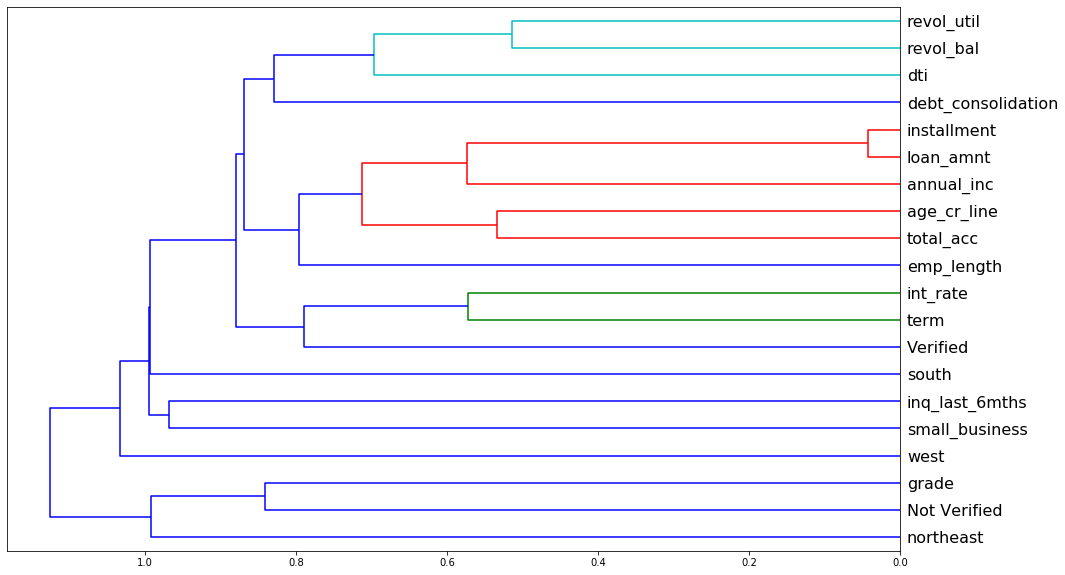

In [26]:
corr = np.round(scipy.stats.spearmanr(X_train_imp).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 10))
dendogram = hc.dendrogram(z, labels=X_train_imp.columns, orientation='left', leaf_font_size=16)
plt.show()

Dendogram clearly shows high rank correlation between "installment" and "loan_amnt". That is actually intuitive
since the loan amount will tipicaly be equaly spread over term into instalments. So high positive correlation makes sense. Let's train the model and check if it hurts the score:

In [27]:
eval_set = [(X_train_imp.drop(["loan_amnt"], axis=1), y_train), (X_valid_imp.drop("loan_amnt", axis=1), y_valid)]

In [28]:
m.fit(X_train_imp.drop(["loan_amnt"], axis=1), y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=True)

[0]	validation_0-auc:0.675064	validation_1-auc:0.644056
[1]	validation_0-auc:0.688637	validation_1-auc:0.653316
[2]	validation_0-auc:0.69056	validation_1-auc:0.653229
[3]	validation_0-auc:0.702698	validation_1-auc:0.658806
[4]	validation_0-auc:0.705767	validation_1-auc:0.661977
[5]	validation_0-auc:0.70602	validation_1-auc:0.661621
[6]	validation_0-auc:0.704873	validation_1-auc:0.661354
[7]	validation_0-auc:0.703582	validation_1-auc:0.65983
[8]	validation_0-auc:0.703342	validation_1-auc:0.660725
[9]	validation_0-auc:0.702688	validation_1-auc:0.660416
[10]	validation_0-auc:0.704053	validation_1-auc:0.662253
[11]	validation_0-auc:0.703691	validation_1-auc:0.6632
[12]	validation_0-auc:0.702976	validation_1-auc:0.663007
[13]	validation_0-auc:0.705357	validation_1-auc:0.664645
[14]	validation_0-auc:0.705225	validation_1-auc:0.663479
[15]	validation_0-auc:0.705341	validation_1-auc:0.664198
[16]	validation_0-auc:0.70731	validation_1-auc:0.666051
[17]	validation_0-auc:0.70835	validation_1-auc:

[144]	validation_0-auc:0.762265	validation_1-auc:0.682689
[145]	validation_0-auc:0.762265	validation_1-auc:0.682689
[146]	validation_0-auc:0.762444	validation_1-auc:0.682876
[147]	validation_0-auc:0.762573	validation_1-auc:0.682896
[148]	validation_0-auc:0.762689	validation_1-auc:0.682959
[149]	validation_0-auc:0.762711	validation_1-auc:0.682879
[150]	validation_0-auc:0.762803	validation_1-auc:0.682799
[151]	validation_0-auc:0.762803	validation_1-auc:0.682799
[152]	validation_0-auc:0.763062	validation_1-auc:0.682844
[153]	validation_0-auc:0.763062	validation_1-auc:0.682844
[154]	validation_0-auc:0.763615	validation_1-auc:0.68282
[155]	validation_0-auc:0.76368	validation_1-auc:0.682866
[156]	validation_0-auc:0.763725	validation_1-auc:0.682796
[157]	validation_0-auc:0.763875	validation_1-auc:0.682723
[158]	validation_0-auc:0.763912	validation_1-auc:0.682734
[159]	validation_0-auc:0.76418	validation_1-auc:0.682658
[160]	validation_0-auc:0.764303	validation_1-auc:0.682841
[161]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4141,
       eval_set=[(       midwest  northeast  south  west  car  credit_card  debt_consolidation  \
2906       0.0        0.0    1.0   0.0  0.0          0.0                 0.0
25978      0.0        1.0    0.0   0.0  0.0          0.0                 0.0
6258       0.0        0.0    0.0   1.0  0.0      ...50     1
7781     1
17861    1
14208    1
39553    1
Name: loan_status, Length: 3974, dtype: int64)],
       gamma=1.3974, importance_type='gain', learning_rate=0.0775,
       max_delta_step=0, max_depth=6, min_child_weight=6, missing=None,
       n_estimators=169, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.0545,
       seed=None, silent=True, sub_sample=0.4799, subsample=1)

Since removing loan_amnt doesn't hurt the score I will remove it from the dataset:

In [29]:
X_train_imp.drop(["loan_amnt"], axis=1, inplace=True)
X_valid_imp.drop(["loan_amnt"], axis=1, inplace=True)

### 4. Model interpretation

In [30]:
prm_imp = PermutationImportance(m, random_state=22).fit(X_valid_imp, y_valid)
show_weights(prm_imp, feature_names=X_train_imp.columns.to_list())

Weight,Feature
0.0561 ± 0.0102,annual_inc
0.0388 ± 0.0023,age_cr_line
0.0327 ± 0.0069,int_rate
0.0305 ± 0.0076,installment
0.0212 ± 0.0118,grade
0.0201 ± 0.0031,revol_bal
0.0200 ± 0.0019,revol_util
0.0167 ± 0.0092,inq_last_6mths
0.0159 ± 0.0079,total_acc
0.0153 ± 0.0062,small_business


It looks like the "annual_inc" is the most informative feature. Let's plot it's partial depandence plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


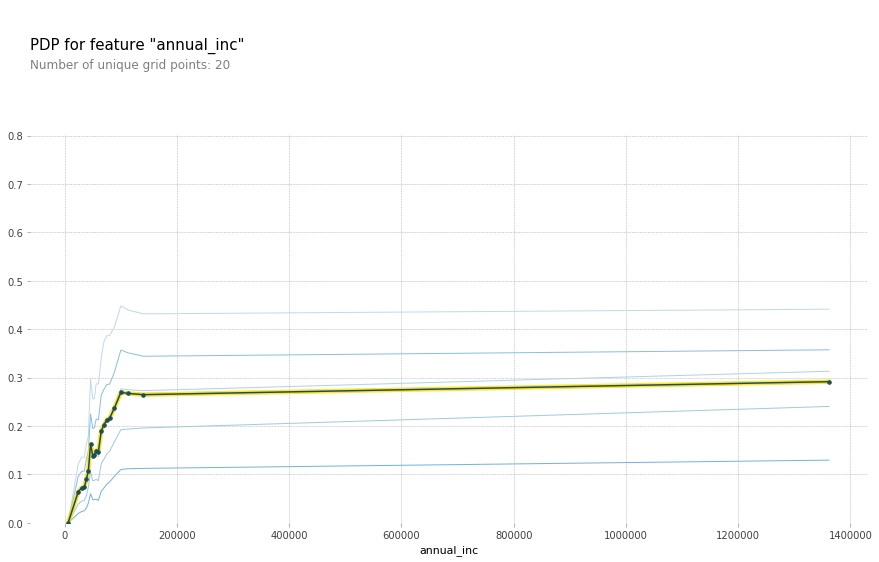

In [31]:
pdp_annual_inc = pdp.pdp_isolate(model=m, dataset=X_valid_imp, 
                                 model_features=X_train_imp.columns.to_list(), 
                                 feature="annual_inc",
                                 num_grid_points=20
                                )
pdp.pdp_plot(pdp_annual_inc, "annual_inc", cluster=True, n_cluster_centers=5)
plt.show()

It looks like there is a postive correlation between the amount money a borrower makes and the probability it will not default. Let's run a two-tailed t-test with 1% significance to check the hypothesis:
* Under null hypothesis there is no difference in annual income between borrowers how defaulted and those who didn't
* Under alternative hypothesis there is difference either positive or negative

In [32]:
ai_1 = X_train_imp.annual_inc[y_train == 1]
ai_0 = X_train_imp.annual_inc[y_train == 0]
print(f'ai_1 size: {ai_1.shape[0]}\nai_0 size: {ai_0.shape[0]}')

ai_1 size: 30671
ai_0 size: 5088


I'm assuming that observations within each set are independent as well as the two sets are independent from each other. 
Sizes need to be similar, so I'm going to randomly sample 5088 observations from ai_1

In [33]:
ai_1 = ai_1.sample(n=5088, axis=0, random_state=44)
ai_1.size

5088

*Let's check the normality of the two sets:*

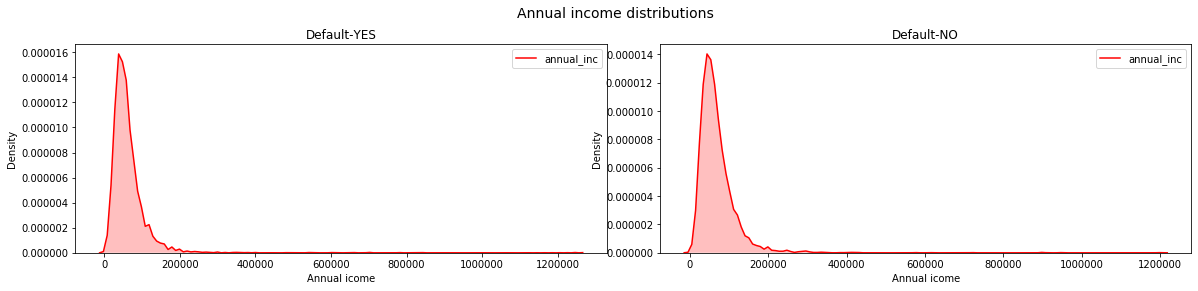

In [34]:
fig = plt.figure(figsize=(20,4))
title = fig.suptitle("Annual income distributions", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.1)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Default-YES")
ax1.set_xlabel("Annual icome")
ax1.set_ylabel("Density") 
sns.kdeplot(ai_0, ax=ax1, shade=True, color='r')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Default-NO")
ax2.set_xlabel("Annual icome")
ax2.set_ylabel("Density") 
sns.kdeplot(ai_1, ax=ax2, shade=True, color='r')

In [35]:
st.ttest_ind(ai_1, ai_0)

Ttest_indResult(statistic=6.636421274524119, pvalue=3.37755397356723e-11)

The conclusion is that there is in fact a significant difference in annual income between the borrowers who had defaulted and those who had not.

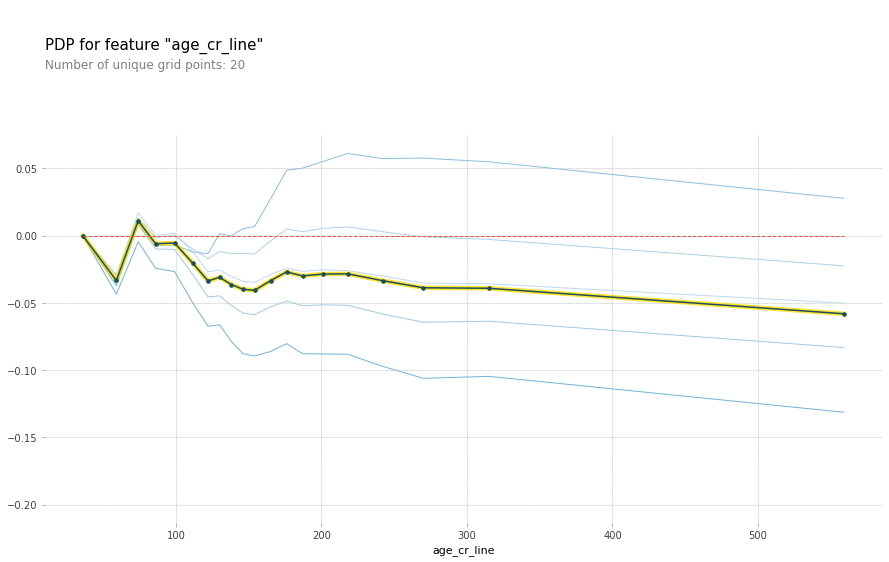

In [36]:
pdp_annual_inc = pdp.pdp_isolate(model=m, dataset=X_valid_imp, 
                                 model_features=X_train_imp.columns.to_list(), 
                                 feature="age_cr_line",
                                 num_grid_points=20
                                )
pdp.pdp_plot(pdp_annual_inc, "age_cr_line", cluster=True, n_cluster_centers=5)
plt.show()

From the age_cr_line partial depandence plot we can see that there is a cluster of borrowers who have lower default rate despite general trend older the credit line the more likely default is.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


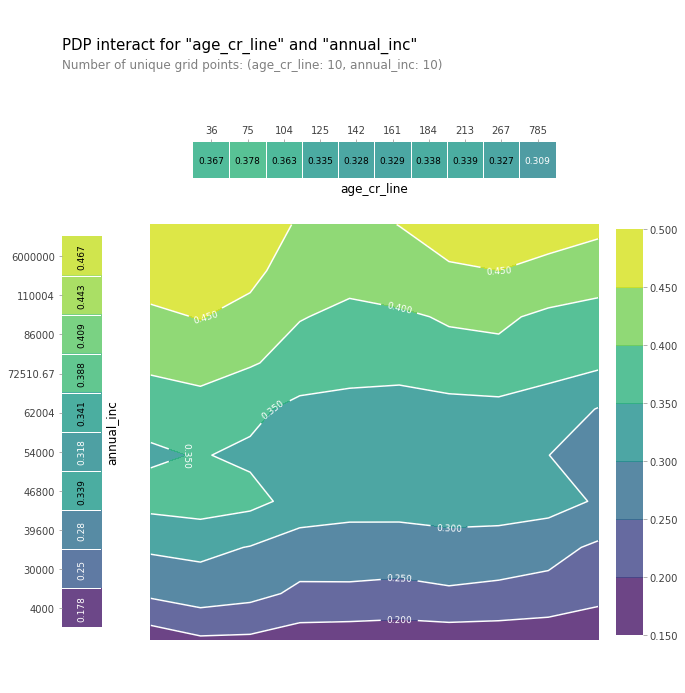

In [37]:
features_to_plot = ['age_cr_line', 'annual_inc']
inter1  =  pdp.pdp_interact(model=m, 
                            dataset=X_train_imp, 
                            model_features=X_train_imp.columns.to_list(), 
                            features=features_to_plot
                           )

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', plot_pdp=True)
plt.show()

From this 2D partial dependence plot we can see that for a fixed annual income that is higher than average, riskier borrowers are those with realy young age of credit line and those with realy old age of credit line. Borrowers with lower than average income are risky regardless of their age credit line.
It would be interesting to group borrowers based on their income and age credit line and see whether that imporves the model score.

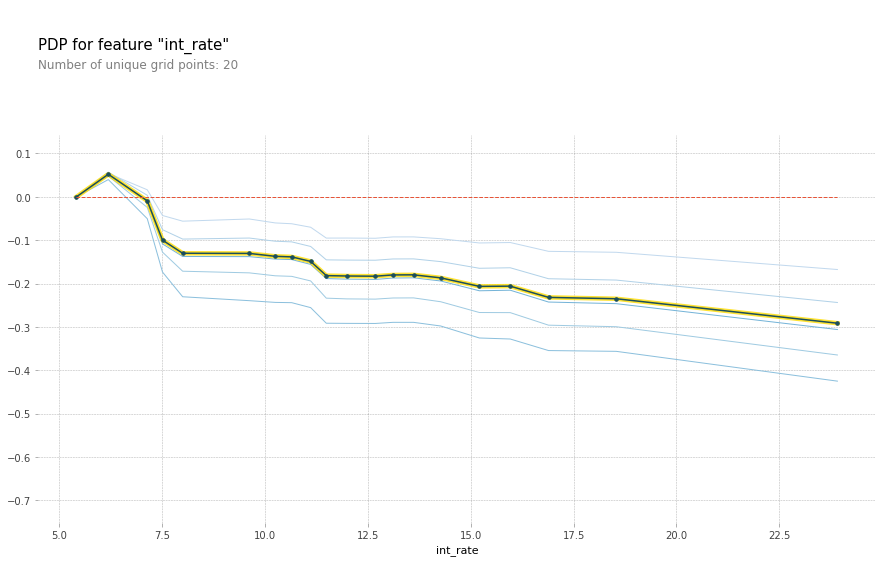

In [38]:
pdp_annual_inc = pdp.pdp_isolate(model=m, dataset=X_valid_imp, 
                                 model_features=X_train_imp.columns.to_list(), 
                                 feature="int_rate",
                                 num_grid_points=20
                                )
pdp.pdp_plot(pdp_annual_inc, "int_rate", cluster=True, n_cluster_centers=5)
plt.show()

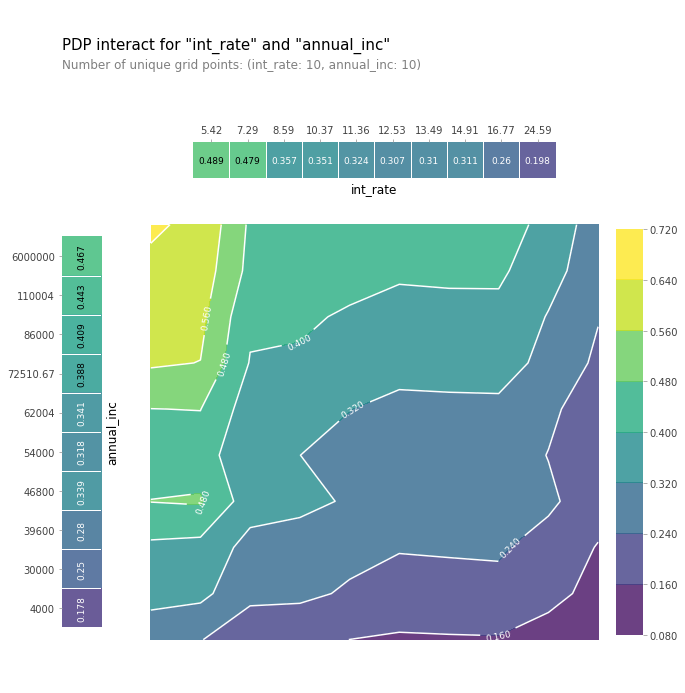

In [39]:
features_to_plot = ['int_rate', 'annual_inc']
inter1  =  pdp.pdp_interact(model=m, 
                            dataset=X_train_imp, 
                            model_features=X_train_imp.columns.to_list(), 
                            features=features_to_plot
                           )

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', plot_pdp=True)
plt.show()

We can see that for a fixed income higher interest rate greatly increases the default chances.

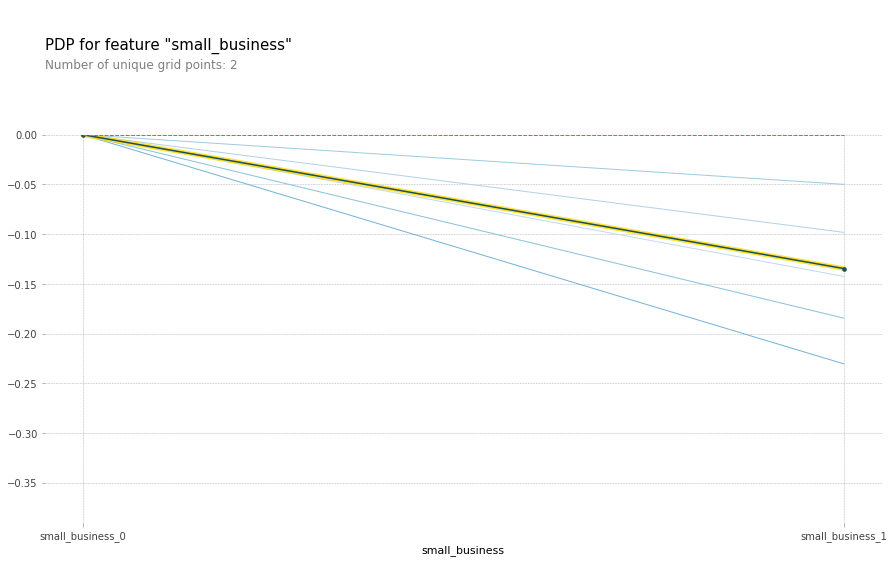

In [40]:
pdp_annual_inc = pdp.pdp_isolate(model=m, dataset=X_valid_imp, 
                                 model_features=X_train_imp.columns.to_list(), 
                                 feature="small_business",
                                 num_grid_points=20
                                )
pdp.pdp_plot(pdp_annual_inc, "small_business", cluster=True, n_cluster_centers=5)
plt.show()

In [41]:
print(f'size of y=1: {X_train_imp.small_business[y_train == 1].shape[0]}\nsize of y=0: {X_train_imp.small_business[y_train == 0].shape[0]}')

size of y=1: 30671
size of y=0: 5088


In [42]:
subsample = X_train_imp.small_business[y_train == 1].sample(5088, axis=0, random_state=22)

In [43]:
sb_1 = subsample.sum() / subsample.shape[0]
sb_0 = X_train_imp.small_business[y_train == 0].sum() / X_train_imp.small_business[y_train == 0].shape[0]
print(f'fraction of small business loans in non-defaulters: {sb_1}\nfraction of small business loans in defaulters: {sb_0}')

fraction of small business loans in non-defaulters: 0.04068396226415094
fraction of small business loans in defaulters: 0.08411949685534591


Since the observations are independent and sample sizes are bigger than 10 I can run a test on the difference:

In [44]:
st.ttest_ind(subsample, X_train_imp.small_business[y_train == 0])

Ttest_indResult(statistic=-9.093099863770378, pvalue=1.1421852096033121e-19)

We can safely claim that on average borrowers who had applied for a small business loan have defaulted on their loan more often than those who applied for a loan for a different purpose.